In [23]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
llm=ChatGroq(model="qwen-2.5-32b")

In [24]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


class State(TypedDict):
    input_code:str
    coder_code:str
    review_code:str
    final_code:str

In [25]:
def coder(state: State):
    data = llm.invoke(f"Please write python code for {state['input_code']} and provide only python code")
    return {"coder_code": data.content}

def reviewer(state: State):
    data = llm.invoke(f"Please take this snippet code {state['coder_code']} and review it.if any error or warning or modification required please return only 'False' else 'True'")
    return {"review_code": data.content}

def check_required(state: State):
    if state['review_code'] == 'False':
        return 'False'
    else:
        return 'True'

def manager_check(state: State):
    data = llm.invoke(f"Please analyze and add doc string for the provided snippet code {state['coder_code']}")
    return {"final_code": data.content}

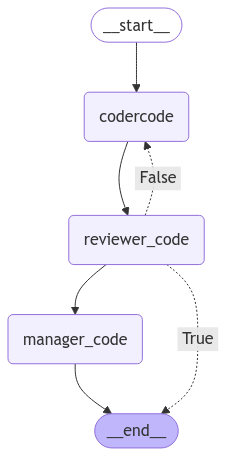

In [26]:

workflow = StateGraph(State)
workflow.add_node("codercode", coder)
workflow.add_node("reviewer_code", reviewer)
workflow.add_node("manager_code", manager_check)


workflow.add_edge(START, "codercode")
workflow.add_edge("codercode", "reviewer_code")
workflow.add_conditional_edges("reviewer_code", check_required, {'False':'codercode', 'True':END})
workflow.add_edge("reviewer_code", "manager_code")
workflow.add_edge("manager_code", END)

chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))



In [27]:
state = chain.invoke({"input_code": """@app.get('/')
def home():
    return {"Message": 'Hello World'}"""})



In [28]:
state

{'input_code': '@app.get(\'/\')\ndef home():\n    return {"Message": \'Hello World\'}',
 'coder_code': '```python\nfrom fastapi import FastAPI\n\napp = FastAPI()\n\n@app.get(\'/\')\ndef home():\n    return {"Message": \'Hello World\'}\n```',
 'review_code': 'True',
 'final_code': 'Certainly! Below is the provided code snippet with an added docstring that explains what the code does:\n\n```python\nfrom fastapi import FastAPI\n\n# Initialize a FastAPI app\napp = FastAPI()\n\n# Define a route for the home endpoint\n@app.get(\'/\')\ndef home():\n    """\n    This function handles GET requests to the root URL (\'/\').\n    \n    Returns:\n        dict: A dictionary containing a simple greeting message.\n    """\n    return {"Message": \'Hello World\'}\n```\n\n### Explanation of the Docstring:\n- **Function Purpose:** The docstring explains that this function handles GET requests to the root URL (\'/\').\n- **Return Value:** It specifies that the function returns a dictionary containing a si